In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import emcee



%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [92]:
emcee_outputdir = "emcee_output"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_z=0.0"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_z_0.0_nwalkers_1000"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_RadioModeEfficiency_z_0.0_nwalkers_1000"
chain_filename = f"{emcee_outputdir}/sage_emcee_{chain_name}.hdf5"


In [93]:
def get_labels_from_chain_name(chain_name):
    labels = []
    for label in chain_name.split('_'):
        if label.startswith('z'): break
        labels.append(label)
    print(f"{labels =}")
    return labels


In [107]:
def plot_walkers(reader, labels):
    import matplotlib.pyplot as plt
    _, burnin, thin = get_tau_from_reader(reader)
    chain = reader.get_chain(discard=burnin, thin=thin)
    ndim = len(labels)
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(chain[:, :, i], "k", alpha=0.01)
        ax.set_xlim(0, len(chain))
        ax.set_ylabel(labels[i], fontsize=20)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("iteration", fontsize=20);

In [98]:
def sage_param_to_axis_labels(params):
    param_mapping = {'SfrEfficiency': r"$\epsilon_{sfr}$",
                     'ReIncorporationFactor': r"$f_{reinc}$",
                     'FeedbackReheatingEpsilon': r"$\eta_{reheat}$",
                     'RadioModeEfficiency': r"$f_{radio}$"
                     }

    return [param_mapping[k] if k in param_mapping.keys() else k for k in params]

In [102]:
def plot_contours_and_ci(reader, labels, **kwargs):
    import corner
    import numpy as np
    from IPython.display import display, Math

    _, burnin, thin = get_tau_from_reader(reader)
    titles = sage_param_to_axis_labels(labels)
    flat_chain = reader.get_chain(discard=burnin, flat=True, thin=thin)

    # flat_chain = reader.get_chain(flat=True)
    fig = corner.corner(flat_chain, titles=titles, **kwargs)
    # fig.tight_layout()
    ndim = len(labels)
    for i in range(ndim):
        mcmc = np.percentile(flat_chain[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))


In [103]:
def get_tau_from_reader(reader):
    tau = 0.0
    try:
        tau = reader.get_autocorr_time()
    except:
        print("Error getting auto-correlation time")
        tau = 1000.0
        pass

    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    print(f"{burnin = } {thin = } {tau = }")
    return tau, burnin, thin

In [100]:
reader = emcee.backends.HDFBackend(chain_filename, name=chain_name, read_only=True)
labels = get_labels_from_chain_name(chain_name)

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
chain = reader.get_chain(discard=burnin, thin=thin)
#flatchain = reader.get_chain(discard=burnin, flat=True, thin=thin)
#log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
#log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print(f"{burnin = }")
print(f"{thin =}")

plot_walkers(reader, labels)
plot_contours_and_ci(reader, labels)
# print("flat chain shape: {0}".format(chain.shape))
# print("flat log prob shape: {0}".format(log_prob_samples.shape))
# print("flat log prior shape: {0}".format(log_prior_samples.shape))

labels =['SfrEfficiency', 'ReIncorporationFactor', 'FeedbackReheatingEpsilon', 'RadioModeEfficiency']


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 151;
tau: [551.34151984 555.63683577 406.71454495 588.06966858]

Error getting auto-correlation time
burnin = 2000 thin = 500 tau = 1000.0


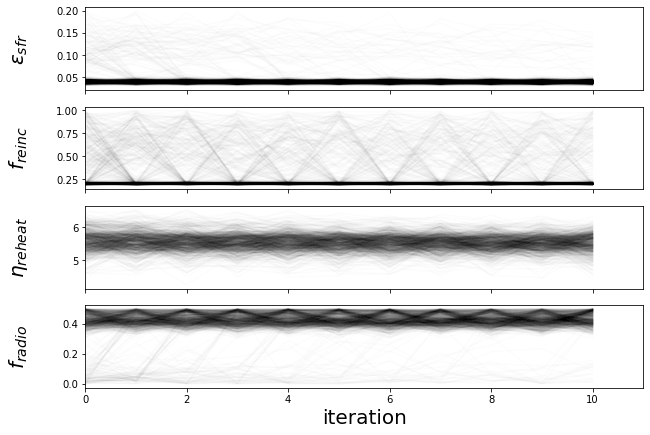

In [108]:
plot_walkers(reader, sage_param_to_axis_labels(labels))

truths = [0.05, 0.15, 3.0, 0.08]
burnin = 2000 thin = 500 tau = 1000.0


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

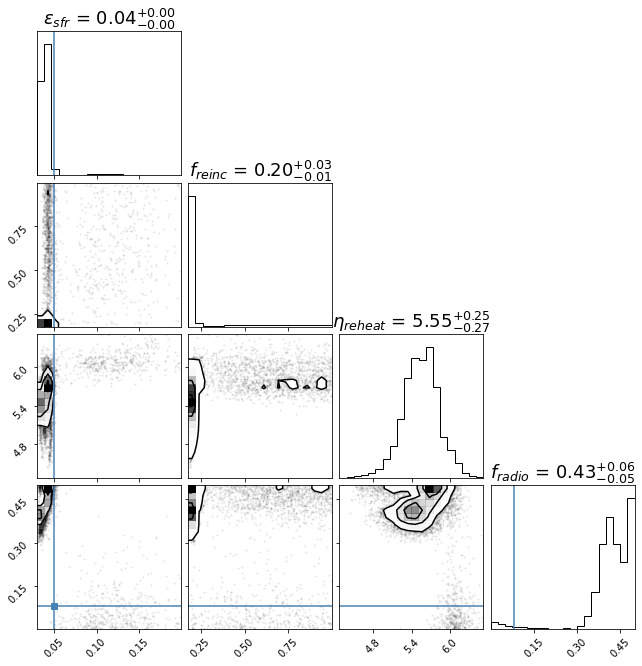

In [96]:
sage_fiducial_params = {'SfrEfficiency': 0.05,
                        'ReIncorporationFactor': 0.15,
                        'FeedbackReheatingEpsilon': 3.0,
                        'RadioModeEfficiency': 0.08
                        }


truths = [sage_fiducial_params[k] for k in labels]
print(f"{truths = }")
plot_contours_and_ci(reader, sage_param_to_axis_labels(labels),
                     truths=truths,
                     show_titles=True,
                     label_kwargs={"fontsize":20}, title_kwargs={"fontsize": 18}, max_n_ticks=4)